# **Child Mind Institute - Relating Physical Activity to Problematic Internet Use**

‣ GitHub page for this project 👉  [here]()

‣ An article from the institute on Summer Screen Time Use 👉  [read here](https://childmind.org/article/screen-time-and-summer/)



### The Problem at Hand 🧑‍💻 *(taken from the comptetition homepage 👉  [read here](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview))*

"In today’s digital age, problematic internet use among children and adolescents is a growing concern. Better understanding this issue is crucial for addressing mental health problems such as depression and anxiety.

Current methods for measuring problematic internet use in children and adolescents are often complex and require professional assessments. This creates access, cultural, and linguistic barriers for many families. Due to these limitations, problematic internet use is often not measured directly, but is instead associated with issues such as depression and anxiety in youth.

Conversely, physical & fitness measures are extremely accessible and widely available with minimal intervention or clinical expertise. Changes in physical habits, such as poorer posture, irregular diet, and reduced physical activity, are common in excessive technology users. We propose using these easily obtainable physical fitness indicators as proxies for identifying problematic internet use, especially in contexts lacking clinical expertise or suitable assessment tools."

**What does this mean?** The Child Mind Institute has tasked the public with building predictive machine learning models that will determine a participant's Severity Impairment Index (SII), which is a metric measuring the level of problematic internet use among children and adolescents, based on physical activity, health, and lifestyle factors. The aim is to identify signs of problematic internet use early so that preventative measures can be taken by the parent/ caretaker.

### The Data at Hand 📊

We will be working with the Child Mind Institute's *Healthy Brain Network (HBN)* dataset, a clinical sample of roughly 5,000 youth and adolescents (aged 5-22) that have undergone various clinical and research screenings for the institute. The institute has conveniently separated for us the relevant data into two distinct categories.

The first is tabular data comprising measurements from various instruments, assessments, and questionairres - in particular, it includes an assessment called the Parent-Child Internet Addiction Test (PCIAT), which is used to calculate the SII of each participant - we'll refer to this data as **feature data**. The second is time-series data collected with a wrist accelerometer given to roughly 1,000 participants to wear for up to 30 days continually while at home and going about their daily lives. The data collected from this device includes physical activity and other metrics - we'll refer to this data as **actigraphy data**.

For each we have been provided with a **train set**, on which we will train our models, and a **test set**, on which we will evaluate their performance. The train set is a full dataset that includes the SII, which is our **target variable**, and the PCIAT results used to calculate it - the test set is a much smaller collection of data that is missing this information. Our objective then is to train the models to accurately predict SII values *for each entry in the test set*.

Because the natures of the feature data and the actigraphy data are vastly different, we will use an **ensemble approach**, analyzing, feature engineering and training models separately, then merging results for the final submission. The actigraphy data is dense time-series data, which means we will get a lot of value from training a neural network on it. For the feature data, simpler baseline ML models should be appropriate. 

### Competition Evaluation 📝

The result will be evaluated based on the **quadratic weighted kappa**, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). The submission file will consist of two rows, one for id and one for SII, with an entry for each participant in the test set. An example submission has been given to us on the Kaggle page.

In [1]:
# load pandas
import pandas as pd

# load sample submission
sample = pd.read_csv("/Users/tomragus/Library/CloudStorage/OneDrive-UCSanDiego/CMI-PIU-Model/data/sample_submission.csv")

# display sample submission
print("Sample submission")
print(f"Submission shape: {sample.shape}")
sample

Sample submission
Submission shape: (20, 2)


,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,2
3,00115b9f,3
4,0016bb22,0
5,001f3379,1
6,0038ba98,2
7,0068a485,3
8,0069fbed,0
9,0083e397,1


### Credit 📚

Parts of this notebook, particularly in the EDA stage, were adapted from [Antonina Dolgorukova](https://datadelic.dev/)'s brilliant EDA notebooks for this competition. I highly encourage checking out her work - they are extremely in-depth and very well written.

‣ *Feature EDA 👉  [read here](https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-features-eda/notebook)*

‣ *Actigraphy EDA 👉  [read here](https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda)*


## ***Feature data***

### Let's start by taking a peek into our feature data:

In [2]:
# load train set
train = pd.read_csv("/Users/tomragus/Library/CloudStorage/OneDrive-UCSanDiego/CMI-PIU-Model/data/train.csv")

# display first 5 rows of train set
print("""Train set: where the 'features' live""")
print(f"Train shape: {train.shape}")
display(train.head())

Train set: where the 'features' live
Train shape: (3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# load test set
test = pd.read_csv("/Users/tomragus/Library/CloudStorage/OneDrive-UCSanDiego/CMI-PIU-Model/data/test.csv")

# display first 5 rows of test set
print("""Test set: what we will evaluate our models on""")
print(f"Test shape: {test.shape}")
display(test.head())

Test set: what we will evaluate our models on
Test shape: (20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It can be tricky to figure out what all of these abbreviations mean - thankfully, the Child Mind Institute was kind enough to include a **data dictionary** for this competition, which gives some extra information for each variable. Here is a little preview - [you can view the full file on the Kaggle page](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data?select=data_dictionary.csv).

In [4]:
# load data dictionary
data_dict = pd.read_csv("/Users/tomragus/Library/CloudStorage/OneDrive-UCSanDiego/CMI-PIU-Model/data/data_dictionary.csv")

# display first 5 rows of data dictionary
print("""Data Dictionary: what each feature means""")
print(f"Data Dictionary shape: {data_dict.shape}")
display(data_dict.head())

Data Dictionary: what each feature means
Data Dictionary shape: (81, 6)


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


While this only gives us a snippet of the data at hand, we can see the SII and the PCIAT scores on the right side of the train set. The SII scores range from 0 to 3, with 0 representing no impairment, and 3 representing severe impairment. So, we can think of the problem as training our models to **classify** each id in the test set into one of the 4 SII classes (0, 1, 2 or 3). Classification calls for **supervised learning**.

Looking at the shape of the train set, we can see that the train set has almost 4,000 entries 🤯 this is good - the more data we have, the more finely we can tune our models.

### Loading the rest of our libraries...

In [5]:
# load all libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
import warnings
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore", category=RuntimeWarning)

### **Exploratory Data Anlaysis - Feature Data**

Let us first analyze observe the features that are related to the SII and are not present in the test set.

In [6]:
# isolating train-only features
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))

# addind additional information using data dictionary
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


Here we see each item in the Parent-Child Internet Addiction Test (PCIAT). Each question (third column) assesses a different aspect of a child's behavior related to internet use, and responses are given on a scale from 0 to 5 with the total score providing an indication of the severity of internet addiction.

We also have the season of participation in PCIAT-Season and total score in PCIAT-PCIAT_Total; so there are a total of 22 PCIAT test-related columns.

Now we will verify that the PCIAT-PCIAT_Total aligns with the corresponding SII categories by calculating the minimum and maximum scores for each SII category.

In [7]:
# calculate max and min
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'})
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [8]:
# display range for each level of severity
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

One thing to take into account is that some of the items in the PCIAT were ignored by participants, leading to missing values. 

In [9]:
# display PCIAT results with missing values highlighted
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.map(lambda x: 'background-color: #FFC0CB' if pd.isna(x) else '')

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


**Problem:** the SII score is calculated by adding together all of the non-NA values in the test, which means a participant can ignore every question (like the second participant) and get a score of 0 - entries like this are not valid, and will skew the results. We can assume then that the SII score can sometimes be incorrect.

This can be addressed by recalculating the SII scores ourselves based on PCIAT_Total and the maximum possible score *IF* missing values were answered, ensuring that the recalculated SII meets the inteded thresholds even with missing values.

In [ ]:
# define PCIAT columns as variable
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]

# recalculate SII function
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

# overwriting SII with recalc_SII
train['sii'] = train['recalc_sii']

# categorizing SII scores by severity and adding "missing" for missing values
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(train[PCIAT_cols].notna().all(axis=1), np.nan)
sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')
sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

# dropping recalc_SII column
train.drop(columns='recalc_sii', inplace=True)

### Removing missing values
Now with our SII values updated, we can remove all rows that are labeled "missing" in the SII column. *Why?* They're not useful to us, since we are training our models precisely to detect this variable.

In [11]:
# remove rows with missing SII
initial_rows = len(train)
train = train[train['sii'] != 'Missing']
train['sii'] = train['sii'].cat.remove_unused_categories()
removed_rows = initial_rows - len(train)
print(f"Removed {removed_rows} rows with 'Missing' SII values.")
print(f"Train shape: {train.shape}")


Removed 1241 rows with 'Missing' SII values.
Train shape: (2719, 83)


Before we begin, let's quickly define a function to generate summary statistics for a given - this will make analysis easier and more efficient.

In [12]:
# define calculate stats function
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

### Analyzing the target variable

Let's conduct some simple analysis on the SII and PCIAT variables.

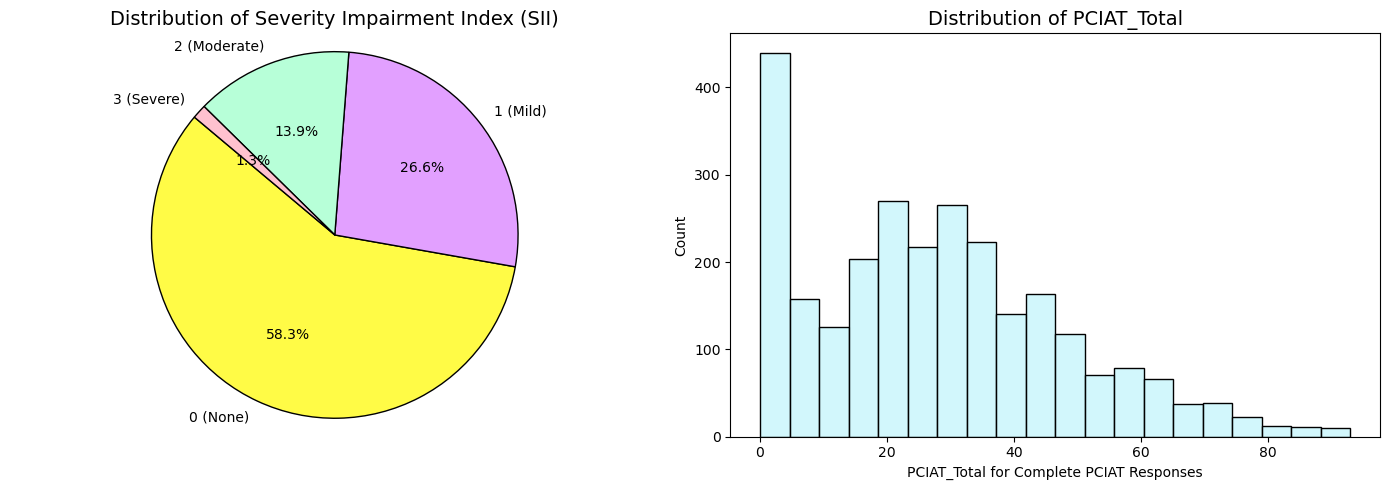

In [ ]:
# define variables for plotting
sii_counts = train['sii'].value_counts().reset_index()
sii_counts.columns = ['SII', 'Count']
total = sii_counts['Count'].sum()
sii_counts['percentage'] = (sii_counts['Count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# custom color pallete (used throughout)
custom_palette = ['#FFFB46', '#E2A0FF', '#B7FFD8', '#FFC1CF', '#C4F5FC']

axes[0].pie(
    sii_counts['Count'],
    labels=sii_counts['SII'],
    autopct='%1.1f%%',
    colors=custom_palette,
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axes[0].set_title('Distribution of Severity Impairment Index (SII)', fontsize=14)
axes[0].axis('equal')  # Equal aspect ratio makes the pie a circle

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, color='#C4F5FC', ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

We can notice that 60% of participants are supposedly not affected by internet use, 26% are mildly impaired, and only a little over 1% are severely impaired. PCIAT scores seem to mostly follow a normal curve, though with many participants answering 0 on all questions - with reasonable assurance, we can assume some of these responses are disingenuous. 

Let us now use our handy *calculate_stats* funtion to take a look at some essential demographics for participants in the study, age, sex, and SII distribution across these demographics.

In [ ]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

# participant age distribution
train['Age Group'] = pd.cut(train['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)'])
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2061 (75.8%)
Adolescents (13-18),623 (22.91%)
Adults (19-22),35 (1.29%)


In [ ]:
# participant sex distribution
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,1729 (63.59%)
Female,990 (36.41%)


In [24]:
# SII distribution by age group
stats_age = train.groupby(['Age Group', 'sii'], observed=False).size().unstack(fill_value=0)
stats_age_prop = stats_age.div(stats_age.sum(axis=1), axis=0) * 100
stats_age = stats_age.astype(str) +' (' + stats_age_prop.round(1).astype(str) + '%)'
stats_age

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,
Children (5-12),1359 (65.9%),493 (23.9%),203 (9.8%),6 (0.3%)
Adolescents (13-18),211 (33.9%),217 (34.8%),169 (27.1%),26 (4.2%)
Adults (19-22),16 (45.7%),12 (34.3%),5 (14.3%),2 (5.7%)


In [25]:
# SII distribution by sex
stats_sex = train.groupby(['Basic_Demos-Sex', 'sii'], observed=False).size().unstack(fill_value=0)
stats_sex_prop = stats_sex.div(stats_sex.sum(axis=1), axis=0) * 100
stats_sex = stats_sex.astype(str) +' (' + stats_sex_prop.round(1).astype(str) + '%)'
stats_sex

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Basic_Demos-Sex,,,,
Female,634 (64.0%),247 (24.9%),101 (10.2%),8 (0.8%)
Male,952 (55.1%),475 (27.5%),276 (16.0%),26 (1.5%)


The tables show that the distribution of SII scores for children and adults is skewed towards lower values, while scores for adolescents are relatively balanced across the categories. We also might notice observe that there are significantly more severe cases for males, although this is slightly misleading since the test sample is heavily skewed male - in actuality, the differences between SII distribution in males and females are not significant.

### Internet Use and SII

Now let us take a closer look at internet usage specifically to see how it relates to SII.

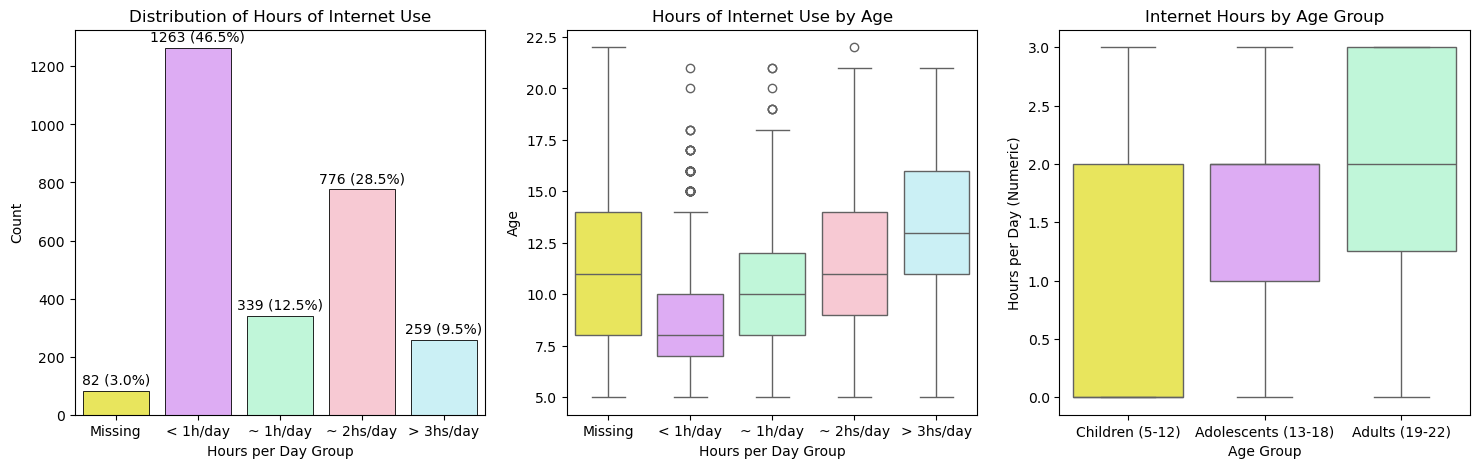

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# generate bar graph, distribution of hours of internet use
ax1 = sns.countplot(x='internet_use_encoded', hue='internet_use_encoded', data=train, palette=custom_palette, legend=False, ax=axes[0], edgecolor='black', linewidth=0.6)
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# generate boxplot, hours of internet use by age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], hue=train['internet_use_encoded'], palette=custom_palette, ax=axes[1], legend=False)
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# generate boxplot, internet hours by age group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', hue='Age Group',data=train, palette=custom_palette[:3], ax=axes[2], legend=False)
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group');

Similar to the earlier SII data, we can see that higher daily internet usage is associated with older age. This hints towards a correlation between internet use and SII.

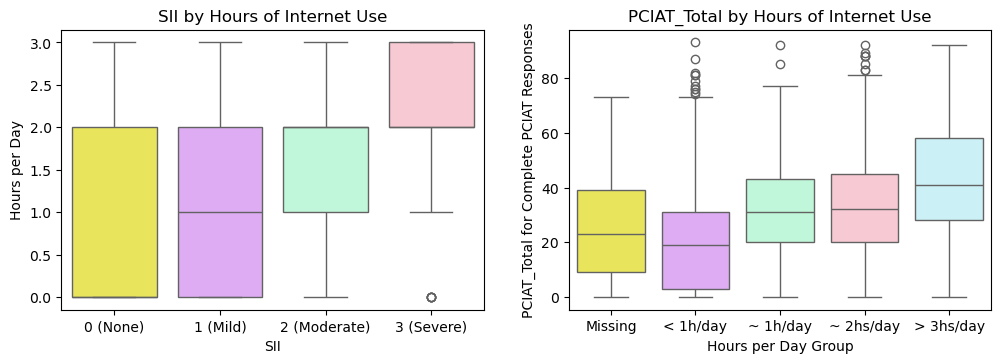

In [64]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# generate boxplot, SII by hours of internet use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(x='sii', y='PreInt_EduHx-computerinternet_hoursday', hue='sii', data=train, ax=ax1, palette=custom_palette[:4], legend=False)
ax1.set_title('SII by Hours of Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# generate boxplot, PCIAT_Total by hours of internet use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='internet_use_encoded', y='complete_resp_total', hue='internet_use_encoded', data=train, palette=custom_palette, ax=ax2, legend=False)
ax2.set_title('PCIAT_Total by Hours of Internet Use')
ax2.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax2.set_xlabel('Hours per Day Group');

Simply tracing your finger along across these plots, a slight upward trend is visible between SII/ PCIAT and hours of internet use, showing their correlation. It might be notable still that there are plenty of participants reporting less than an hour of internet use and still having a high SII score, suggesting that only an hour of internet use can be enough to negatively impact mental health. 

Something to transition into talking about physical metrics...